# Natural Language Pre-Processing & Vectorization

In [ ]:
# Use this to install nltk if needed
# !pip install nltk
# !conda install -c anaconda nltk

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
import string
import re

# Notice that these vectorizers are from `sklearn` and not `nltk`!
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

In [2]:
# Use this to download the stopwords if you haven't already - only ever needs to be run once
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lberlin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Same with wordnet!
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/lberlin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# And with parts of speech tagging!
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package tagsets to /Users/lberlin/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lberlin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Learning Goals

- Describe the basic concepts of NLP
- Use pre-processing methods for NLP
    - Tokenization
    - Stopwords removal
- normalize a lexicon with stemming and lemmatization
- run feature engineering algorithms for NLP
    - bag-of-Words
    - vectorization

# Overview of NLP

NLP allows computers to interact with text data in a structured and sensible way. In short, we will be breaking up series of texts into individual words (or groups of words), and isolating the words with **semantic value**.  We will then compare texts with similar distributions of these words, and group them together.

In this section, we will discuss some steps and approaches to common text data analytic procedures. Some of the applications of natural language processing are:
- Chatbots 
- Speech recognition and audio processing 
- Classifying documents 

Here is an example that uses some of the tools we use in this notebook.  
  -[chicago_justice classifier](https://github.com/chicago-justice-project/article-tagging/blob/master/lib/notebooks/bag-of-words-count-stemmed-binary.ipynb)

We will introduce you to the preprocessing steps, feature engineering, and other steps you need to take in order to format text data for machine learning tasks. 

We will also introduce you to [**NLTK**](https://www.nltk.org/) (Natural Language Toolkit), which will be our main tool for engaging with textual data.

<img src="images/nlp_process.png" style="width:1000px;">

# Preprocessing for NLP

The goal when pre-processing text data for NLP is to remove as many unnecessary words as possible while preserving as much semantic meaning as possible. This will improve your model performance dramatically.

You can think of this sort of like dimensionality reduction. The unique words in your corpus form a **vocabulary**, and each word in your vocabulary is essentially another feature in your model. So we want to get rid of unnecessary words and consolidate words that have similar meanings.

We will be working with a dataset which includes both satirical (The Onion) and real news (Reuters) articles. We refer to the entire set of articles as the **corpus**.  

Each article in the corpus is refered to as a **document**.

![the_onion](images/the_onion.jpeg) ![reuters](images/reuters.png)

In [6]:
# Read in the data, check it out
corpus = pd.read_csv('data/satire_nosatire.csv')
corpus.shape

(1000, 2)

In [7]:
# What does the data look like
corpus.tail()

,body,target
995,Britain’s opposition leader Jeremy Corbyn wou...,0
996,Turkey will take over the fight against Islam...,0
997,Malaysia is seeking $7.5 billion in reparatio...,0
998,An Israeli court sentenced a Palestinian to 1...,0
999,At least 22 people have died due to landslide...,0


Our goal is to detect satire, so our target class of 1 is associated with The Onion articles.  

In [9]:
# Check out a satirical article
corpus.loc[10].body

'In recognition of the brave and altruistic Americans who risk their health and safety for the greater good, Pentagon officials announced Thursday that the U.S. military would honor the sacrifices of NFL players by wearing their jerseys throughout December. “Every week, these men are out there on the gridiron, putting their bodies on the line for our country. Having our soldiers wear these jerseys and caps is the least we can do to show our support,” said Pentagon spokesperson Robert D’Amato, who announced that all active-duty soldiers would be sporting gear from all 32 teams to raise awareness of the people who put their lives aside to preserve the American way of life. “These men leave their homes and their families and travel to cities across the country to uphold our nation’s traditions. They are battered and bruised for years, their lives often cut short while we sit back in our barracks and enjoy our freedom. Some of them are never the same after they end their service, and yet w

In [12]:
# Checkout out a non-satirical article
corpus.loc[502]['body']

' Indonesia will launch a renewed search effort as early as Tuesday to find the cockpit voice recorder from a Lion Air jet that crashed into the Java Sea in October, the head of its accident investigation agency said. “If the weather is good, the ship will start to depart today,” National Transporation Safety Commission (KNKT) Chief Soerjanto Tjahjono told Reuters on Tuesday. The crash, the world’s first of a Boeing Co (BA.N) 737 MAX jet and the deadliest of 2018, killed all 189 people on board. Investigators last week said they planned to use a navy ship for a fresh search for the crashed jet’s second “black box” after a 10-day effort funded by Lion Air failed to find the cockpit voice recorder (CVR). A KNKT source, speaking on condition of anonymity, told Reuters the team will have seven days using the ship KRI Spica to find the CVR, which could hold vital clues giving investigators insight into the actions of the doomed jet’s pilots. Tjahjono declined to comment on whether there was

It is a balanced dataset with 500 documents of each category. 

In [13]:
corpus.target.value_counts()

1    500
0    500
Name: target, dtype: int64

**Discussion:** Let's think about the use cases of being able to correctly separate satirical from authentic news. What might be a real-world use case?  

- 



# NLP Processing By Hand!

Let's go over the many steps involved in processing text data. While some functions or classes we'll use later will do many of these steps for us, we'll walk through each of these manually first so we can discuss why they're important!

## Tokenization 

In order to convert the texts into data suitable for machine learning, we need to break down the documents into smaller parts. 

The first step in doing that is **tokenization**.

Tokenization is the process of splitting documents into units of observations. We usually represent the tokens as __n-grams__, where n represent the number of consecutive words occuring in a document that we will consider a unit. In the case of unigrams (one-word tokens), the sentence "David works here" would be tokenized into:

- "David", "works", "here";

If we want (also) to consider bigrams, we would (also) consider:

- "David works" and "works here".

Let's consider a particular document in our corpus:

In [16]:
corpus.iloc[1]

body      Desperate to unwind after months of nonstop wo...
target                                                    1
Name: 1, dtype: object

In [14]:
sample_document = corpus.iloc[1].body

In [15]:
sample_document

'Desperate to unwind after months of nonstop work investigating Russian influence in the 2016 election, visibly exhausted Special Counsel Robert Mueller powered his phone down Friday in order to give himself a break from any news concerning the probe over the holiday break. “The last thing I want when I’m spending time with my family is a cascade of push notifications telling me yet another Russian oligarch, political operative, or highly placed socialite used Deutsche Bank channels to funnel money to the campaign,” said the former FBI director, firmly holding down his phone’s power button and adding that he wants to be “completely present in the moment” while celebrating with his loved ones, not ruminating about who met with which diplomat or whether someone was using social media to tamper with his witnesses. “I just want to have two calm weeks where I don’t even think about Individual One. I won’t even say his name. I’ll have to wait to hear about any important developments in Janua

There are many ways to tokenize our document. 

It is a long string, so the first way we might consider is to split it by spaces.

In [17]:
# Code here to split it by spaces
tokens = sample_document.split(" ")
tokens[:20]

['Desperate',
 'to',
 'unwind',
 'after',
 'months',
 'of',
 'nonstop',
 'work',
 'investigating',
 'Russian',
 'influence',
 'in',
 'the',
 '2016',
 'election,',
 'visibly',
 'exhausted',
 'Special',
 'Counsel',
 'Robert']

But this is not ideal. We are trying to create a set of tokens with **high semantic value**.  In other words, we want to isolate text which best represents the meaning in each document.

## Text Cleaning

Most NL Pre-Processing will include the following tasks:

  1. Remove capitalization  
  2. Remove punctuation  
  3. Remove stopwords  
  4. Remove numerals
  
We can manually perform all of these tasks with string operations.

### Capitalization

When we create our matrix of words associated with our corpus, **capital letters** will mess things up.  The semantic value of a word used at the beginning of a sentence is the same as that same word in the middle of the sentence - but Python won't treat them the same!

In [18]:
# This will prove that 'excessive' and 'Excessive' aren't the same
sentence_one =  "Excessive gerrymandering in small counties suppresses turnout." 
sentence_two =  "Turnout is suppressed in small counties by excessive gerrymandering."

Excessive = sentence_one.split(' ')[0]
excessive = sentence_two.split(' ')[-2]
print(excessive, Excessive)
excessive == Excessive

excessive Excessive


False

While 'excessive' has the same semantic value, it will be treated as different tokens because of capitals. Let's fix it!

In [19]:
# Code here to remove capital letters and make everything lowercase
# Let's do this for our tokens
manual_cleanup = [token.lower() for token in tokens]
manual_cleanup[:20]

['desperate',
 'to',
 'unwind',
 'after',
 'months',
 'of',
 'nonstop',
 'work',
 'investigating',
 'russian',
 'influence',
 'in',
 'the',
 '2016',
 'election,',
 'visibly',
 'exhausted',
 'special',
 'counsel',
 'robert']

In [21]:
# Check the length of the original number of tokens in sample_document
print(f"Our initial token set for our sample document is {len(tokens)} words long")

Our initial token set for our sample document is 213 words long


In [22]:
# Check the length of the unique number of tokens in sample_document
print(f"Our initial token set for our sample document has {len(set(tokens))} unique words")

Our initial token set for our sample document has 161 unique words


In [23]:
# Check the length of the unique number of tokens after lowercasing
print(f"After removing capitals, our sample document has {len(set(manual_cleanup))} unique words")

After removing capitals, our sample document has 161 unique words


So - it didn't change the number of unique words in our sample document. Part of the reason why is because it's still dealing with punctuation!

### Punctuation

Like capitals, splitting on white space will create tokens which include punctuation that will muck up our semantics.  

Returning to the above example, 'gerrymandering' and 'gerrymandering.' will be treated as different tokens.

In [24]:
# Check out how the same word with and without punctuation aren't the same
no_punct = sentence_one.split(' ')[1]
punct = sentence_two.split(' ')[-1]
print(no_punct, punct)
no_punct == punct

gerrymandering gerrymandering.


False

In [25]:
# Can access punctuation using the string library
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
# Fun way to clean this is using the translate function!
manual_cleanup = [s.translate(str.maketrans('', '', string.punctuation))\
                  for s in manual_cleanup]

In [28]:
manual_cleanup[-5:]

['the', 'news', 'real', 'quick', '']

In [27]:
print(f"After removing punctuation, our sample document has \
{len(set(manual_cleanup))} unique words")

After removing punctuation, our sample document has 158 unique words


We can see that in our sample document, we now have 3 fewer unique tokens! Still more work to do though...

### Stopwords

Stopwords are the **filler** words in a language: prepositions, articles, conjunctions. They have low semantic value, and often need to be removed.  

Luckily, NLTK has lists of stopwords ready for our use.

In [29]:
# Let's check out some English language stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [30]:
# NLTK has stopwords in other languages too!
stopwords.words('greek')[:10]

['αλλα',
 'αν',
 'αντι',
 'απο',
 'αυτα',
 'αυτεσ',
 'αυτη',
 'αυτο',
 'αυτοι',
 'αυτοσ']

Let's see which stopwords are present in our sample document.

In [31]:
# Check out the first 10 stopwords in our sample document
stops = [token for token in manual_cleanup if token in stopwords.words('english')]
stops[:10]

['to', 'after', 'of', 'in', 'the', 'his', 'down', 'in', 'to', 'himself']

In [32]:
print(f'There are {len(stops)} instances of {len(set(stops))} \
stopwords in the sample document')

There are 83 instances of 38 stopwords in the sample document


In [33]:
print(f'The {len(stops)} instances make up \
{len(stops)/len(manual_cleanup): 0.2%} of our text')

The 83 instances make up  38.97% of our text


Let's also use the **FreqDist** tool to look at the makeup of our text before and after removal:

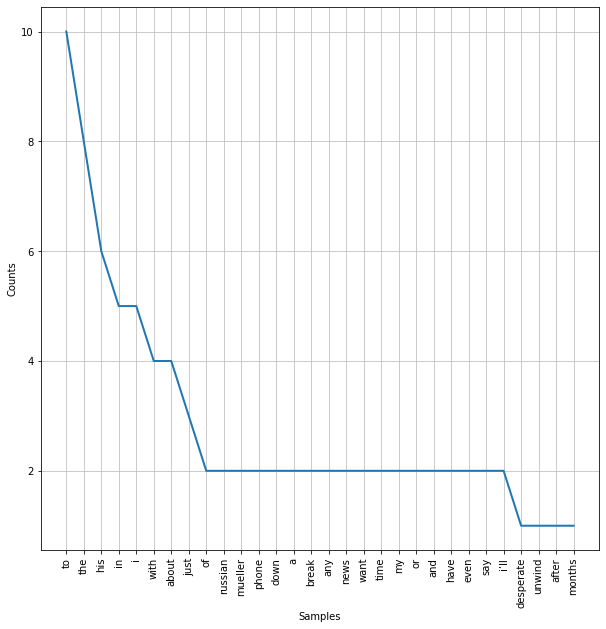

In [34]:
# This FreqDist class from NLTK will help us visualize the frequency of words
fdist = FreqDist(manual_cleanup)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [36]:
# Now let's remove stopwords - use list comprehension
sw = stopwords.words('english')
manual_cleanup = [word for word in manual_cleanup if word not in sw]

In [37]:
print(f'After removing stopwords, there are {len(set(manual_cleanup))} unique words left')

After removing stopwords, there are 120 unique words left


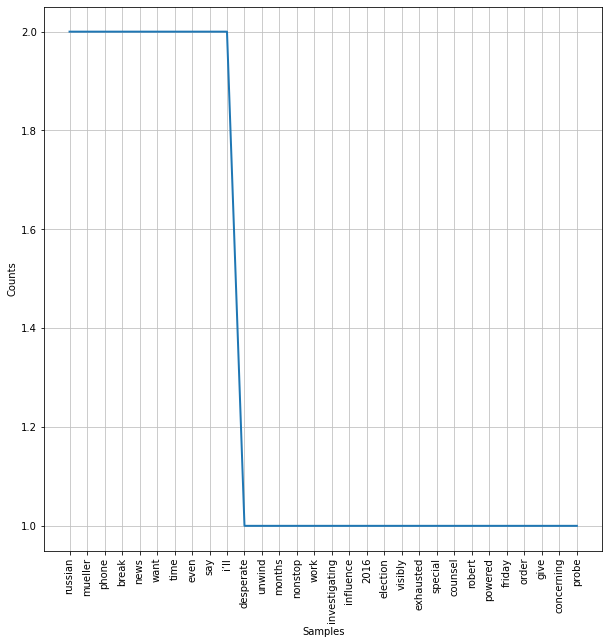

In [38]:
# Now let's check out that frequency distribution
fdist = FreqDist(manual_cleanup)
plt.figure(figsize=(10, 10))
fdist.plot(30);

### Numerals

Numerals also usually have low semantic value. Their removal can help improve our models. 

In [39]:
manual_cleanup = [s.translate(str.maketrans('', '', '0123456789')) \
                  for s in manual_cleanup]

In [40]:
# drop empty strings
manual_cleanup = [s for s in manual_cleanup if s != '']

In [41]:
print(f'After removing numerals, there are {len(set(manual_cleanup))} unique words left')

After removing numerals, there are 118 unique words left


## Regex

Regex allows us to match strings based on a pattern.  This pattern comes from a language of identifiers, which we can begin exploring on the cheatsheet found here:
  -   https://regexr.com/

A few key symbols:
  - . : matches any character
  - \d, \w, \s : represent digit, word, whitespace  
  - *, ?, +: matches 0 or more, 0 or 1, 1 or more of the preceding character  
  - [A-Z]: matches any capital letter  
  - [a-z]: matches lowercase letter  

Other helpful resources:
  - https://regexcrossword.com/
  - https://www.regular-expressions.info/tutorial.html

We can use regex to isolate numerals:

In [42]:
sample_document

'Desperate to unwind after months of nonstop work investigating Russian influence in the 2016 election, visibly exhausted Special Counsel Robert Mueller powered his phone down Friday in order to give himself a break from any news concerning the probe over the holiday break. “The last thing I want when I’m spending time with my family is a cascade of push notifications telling me yet another Russian oligarch, political operative, or highly placed socialite used Deutsche Bank channels to funnel money to the campaign,” said the former FBI director, firmly holding down his phone’s power button and adding that he wants to be “completely present in the moment” while celebrating with his loved ones, not ruminating about who met with which diplomat or whether someone was using social media to tamper with his witnesses. “I just want to have two calm weeks where I don’t even think about Individual One. I won’t even say his name. I’ll have to wait to hear about any important developments in Janua

In [43]:
pattern = '[0-9]'
number = re.findall(pattern, sample_document)
number

['2', '0', '1', '6']

In [44]:
pattern2 = '[0-9]+'
number2 = re.findall(pattern2, sample_document)
number2

['2016']

# Text Processing Using NLTK

## `RegexpTokenizer()`

SKLearn and NLTK provide us with a suite of **tokenizers** for our text preprocessing convenience. So we don't have to do this all by hand every time!

Let's use a provided Regex pattern to do all that work for us!

Documentation: https://tedboy.github.io/nlps/generated/generated/nltk.tokenize.RegexpTokenizer.html


Can use [RegExr](https://regexr.com/) to explore what our pattern, `([a-zA-Z]+(?:'[a-z]+)?)`, is doing exactly.

In [45]:
sample_document

'Desperate to unwind after months of nonstop work investigating Russian influence in the 2016 election, visibly exhausted Special Counsel Robert Mueller powered his phone down Friday in order to give himself a break from any news concerning the probe over the holiday break. “The last thing I want when I’m spending time with my family is a cascade of push notifications telling me yet another Russian oligarch, political operative, or highly placed socialite used Deutsche Bank channels to funnel money to the campaign,” said the former FBI director, firmly holding down his phone’s power button and adding that he wants to be “completely present in the moment” while celebrating with his loved ones, not ruminating about who met with which diplomat or whether someone was using social media to tamper with his witnesses. “I just want to have two calm weeks where I don’t even think about Individual One. I won’t even say his name. I’ll have to wait to hear about any important developments in Janua

In [46]:
# This pattern tokenizes AND removes punctuation
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
# Need to save the tokenizer that uses the regex pattern
tokenizer = RegexpTokenizer(pattern)
# And now tokenize our sample_document with tokenizer.tokenize
sample_tokens = tokenizer.tokenize(sample_document)

In [47]:
# Check out one of the middle sentences - notice what happened to I'm
sample_tokens[42:52]

['The', 'last', 'thing', 'I', 'want', 'when', 'I', 'm', 'spending', 'time']

In [48]:
# Still need to lowercase
sample_tokens = [token.lower() for token in sample_tokens]
# And remove stopwords
sample_tokens = [token for token in sample_tokens if token not in sw]

In [49]:
sample_document

'Desperate to unwind after months of nonstop work investigating Russian influence in the 2016 election, visibly exhausted Special Counsel Robert Mueller powered his phone down Friday in order to give himself a break from any news concerning the probe over the holiday break. “The last thing I want when I’m spending time with my family is a cascade of push notifications telling me yet another Russian oligarch, political operative, or highly placed socialite used Deutsche Bank channels to funnel money to the campaign,” said the former FBI director, firmly holding down his phone’s power button and adding that he wants to be “completely present in the moment” while celebrating with his loved ones, not ruminating about who met with which diplomat or whether someone was using social media to tamper with his witnesses. “I just want to have two calm weeks where I don’t even think about Individual One. I won’t even say his name. I’ll have to wait to hear about any important developments in Janua

In [50]:
print(f'We are down to {len(set(sample_tokens))} unique words')

We are down to 111 unique words


# Exercise: Initial Text Pre-Processing

**Activity:** Use what you've learned to preprocess the fourth article. How does the length and number of unique words in the article change?

In [52]:
# Grab the fourth document
fourth_document = corpus.iloc[3].body
fourth_document

'Attempting to make amends for gross abuses of power during his time as Interior Department Secretary, an unusually contrite Ryan Zinke apologized Monday for misusing government funds by sending the members of the ethics committee a $160,000 vase. “I know this doesn’t change anything about how I exploited my cabinet position, but I hope you will accept this beautiful example of Qing dynasty porcelain as a small token of my regret,” said Zinke, acknowledging that while no gift could make up for the time he spent $139,000 of taxpayer money to renovate his office doors, he hoped the committee would consider the vase as a sincere gesture of apology. “I was wrong to take advantage of my position, and I hope the lustrous glazing and firing evident in this piece will move you to forgive me for my all-too-human failings. Please don’t remember me as the man who used government funds on security detail for my family while we were on vacation in Turkey, or as the man who violated the Hatch Act an

In [53]:
# Check out how many words it has originally
print(f'The 4th document starts off with {len(set(fourth_document.split(" ")))} unique words')

The 4th document starts off with 158 unique words


In [60]:
# Your code here to process and reduce down to useful words!
fourth_tokens = tokenizer.tokenize(fourth_document.lower())

In [61]:
# fourth_tokens = [token.lower() for token in fourth_tokens]
fourth_tokens = [token for token in fourth_tokens if token not in sw]

In [62]:
len(set(fourth_tokens))

110

## Stemming and Lemmatizing

### Stemming
Most of the semantic meaning of a word is held in the root, which is usually the beginning of a word.  Conjugations and plurality do not change the semantic meaning. "eat", "eats", and "eating" all have essentially the same meaning. The rest is grammatical variation for the sake of marking things like tense or person or number.   

Stemmers consolidate similar words by chopping off the ends of the words.

<img src="images/stemmer.png" width=200>

There are different stemmers available.  The two we will use here are the **Porter** and **Snowball** stemmers.  A main difference between the two is how aggressively it stems, Porter being less aggressive.

In [63]:
p_stemmer = nltk.stem.PorterStemmer()
s_stemmer = nltk.stem.SnowballStemmer(language="english")

In [64]:
sample_tokens[0]

'desperate'

In [65]:
p_stemmer.stem(sample_tokens[0])

'desper'

In [66]:
s_stemmer.stem(sample_tokens[0])

'desper'

In [67]:
for word in sample_tokens:
    p_word = p_stemmer.stem(word)
    s_word = s_stemmer.stem(word)
    
    if p_word != s_word:
        print(word, p_word, s_word)

highly highli high
firmly firmli firm


In [69]:
sample_doc = [p_stemmer.stem(word) for word in sample_tokens]

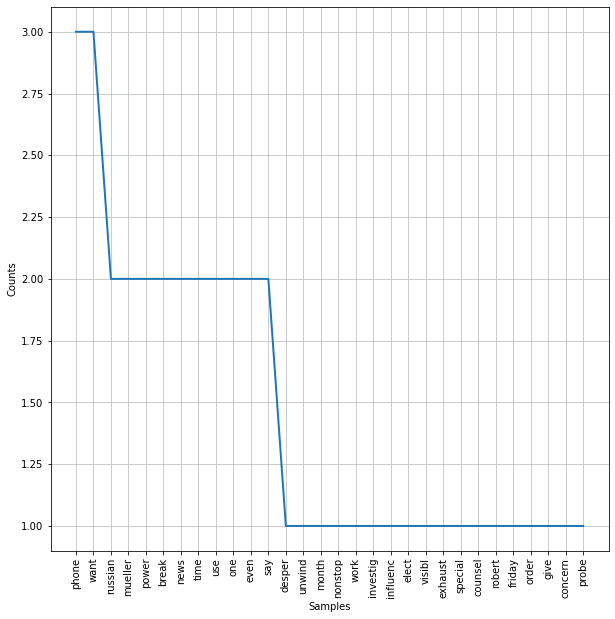

In [70]:
fdist = FreqDist(sample_doc)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [73]:
print(f'Stemming slightly reduced our token count: {len(set(sample_doc))} unique tokens')

Stemming slightly reduced our token count: 107 unique tokens


### Lemmatizing

Lemmatizing is a bit more sophisticated than the stem choppers. Lemmatizing uses part-of-speech tagging to determine how to transform a word.

- Unlike Stemming, Lemmatization reduces the inflected words, properly ensuring that the root word belongs to the language. It can handle words such as "mouse", whose plural "mice" the stemmers would not lump together with the original. 

- In Lemmatization, the root word is called the "lemma". 

- A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

<img src="images/lemmer.png" width=300>

In [74]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [77]:
sample_tokens[76]

'media'

In [78]:
print(f'"Mice" becomes: {lemmatizer.lemmatize("mice")}')
print(f'"{sample_tokens[76]}" becomes: {lemmatizer.lemmatize(sample_tokens[76])}')

"Mice" becomes: mouse
"media" becomes: medium


In [76]:
# However, look at the output below:
sentence = "He saw the trees get sawed down"
lemmed_sentence = [lemmatizer.lemmatize(token) for token in sentence.split(' ')]
lemmed_sentence

['He', 'saw', 'the', 'tree', 'get', 'sawed', 'down']

Lemmatizers depend, for their full functionality, on POS tagging, and **the default tag is 'noun'**.

With a little bit of work, we can POS tag our text.

In [79]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
sample_doc = tokenizer.tokenize(sample_document)
sample_doc = [token.lower() for token in sample_doc]
sample_doc = [token for token in sample_doc if token not in sw]
sample_document

'Desperate to unwind after months of nonstop work investigating Russian influence in the 2016 election, visibly exhausted Special Counsel Robert Mueller powered his phone down Friday in order to give himself a break from any news concerning the probe over the holiday break. “The last thing I want when I’m spending time with my family is a cascade of push notifications telling me yet another Russian oligarch, political operative, or highly placed socialite used Deutsche Bank channels to funnel money to the campaign,” said the former FBI director, firmly holding down his phone’s power button and adding that he wants to be “completely present in the moment” while celebrating with his loved ones, not ruminating about who met with which diplomat or whether someone was using social media to tamper with his witnesses. “I just want to have two calm weeks where I don’t even think about Individual One. I won’t even say his name. I’ll have to wait to hear about any important developments in Janua

In [80]:
# Use nltk's pos_tag to tag our words
# Does a pretty good job, but does make some mistakes

sample_doc_tagged = pos_tag(sample_doc)
sample_doc_tagged

[('desperate', 'JJ'),
 ('unwind', 'JJ'),
 ('months', 'NNS'),
 ('nonstop', 'JJ'),
 ('work', 'NN'),
 ('investigating', 'VBG'),
 ('russian', 'JJ'),
 ('influence', 'NN'),
 ('election', 'NN'),
 ('visibly', 'RB'),
 ('exhausted', 'VBD'),
 ('special', 'JJ'),
 ('counsel', 'NN'),
 ('robert', 'NN'),
 ('mueller', 'NN'),
 ('powered', 'VBD'),
 ('phone', 'NN'),
 ('friday', 'NN'),
 ('order', 'NN'),
 ('give', 'VBP'),
 ('break', 'NN'),
 ('news', 'NN'),
 ('concerning', 'VBG'),
 ('probe', 'NN'),
 ('holiday', 'NN'),
 ('break', 'IN'),
 ('last', 'JJ'),
 ('thing', 'NN'),
 ('want', 'VB'),
 ('spending', 'NN'),
 ('time', 'NN'),
 ('family', 'NN'),
 ('cascade', 'VBD'),
 ('push', 'JJ'),
 ('notifications', 'NNS'),
 ('telling', 'VBG'),
 ('yet', 'RB'),
 ('another', 'DT'),
 ('russian', 'JJ'),
 ('oligarch', 'NN'),
 ('political', 'JJ'),
 ('operative', 'JJ'),
 ('highly', 'RB'),
 ('placed', 'VBN'),
 ('socialite', 'NN'),
 ('used', 'VBN'),
 ('deutsche', 'NN'),
 ('bank', 'NN'),
 ('channels', 'NNS'),
 ('funnel', 'VBP'),
 ('mon

In [81]:
# Then transform the tags into the tags of our lemmatizers

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [82]:
sample_doc_tagged

[('desperate', 'JJ'),
 ('unwind', 'JJ'),
 ('months', 'NNS'),
 ('nonstop', 'JJ'),
 ('work', 'NN'),
 ('investigating', 'VBG'),
 ('russian', 'JJ'),
 ('influence', 'NN'),
 ('election', 'NN'),
 ('visibly', 'RB'),
 ('exhausted', 'VBD'),
 ('special', 'JJ'),
 ('counsel', 'NN'),
 ('robert', 'NN'),
 ('mueller', 'NN'),
 ('powered', 'VBD'),
 ('phone', 'NN'),
 ('friday', 'NN'),
 ('order', 'NN'),
 ('give', 'VBP'),
 ('break', 'NN'),
 ('news', 'NN'),
 ('concerning', 'VBG'),
 ('probe', 'NN'),
 ('holiday', 'NN'),
 ('break', 'IN'),
 ('last', 'JJ'),
 ('thing', 'NN'),
 ('want', 'VB'),
 ('spending', 'NN'),
 ('time', 'NN'),
 ('family', 'NN'),
 ('cascade', 'VBD'),
 ('push', 'JJ'),
 ('notifications', 'NNS'),
 ('telling', 'VBG'),
 ('yet', 'RB'),
 ('another', 'DT'),
 ('russian', 'JJ'),
 ('oligarch', 'NN'),
 ('political', 'JJ'),
 ('operative', 'JJ'),
 ('highly', 'RB'),
 ('placed', 'VBN'),
 ('socialite', 'NN'),
 ('used', 'VBN'),
 ('deutsche', 'NN'),
 ('bank', 'NN'),
 ('channels', 'NNS'),
 ('funnel', 'VBP'),
 ('mon

In [83]:
sample_doc_tagged = [(token[0], get_wordnet_pos(token[1]))
             for token in sample_doc_tagged]

In [84]:
sample_doc_tagged

[('desperate', 'a'),
 ('unwind', 'a'),
 ('months', 'n'),
 ('nonstop', 'a'),
 ('work', 'n'),
 ('investigating', 'v'),
 ('russian', 'a'),
 ('influence', 'n'),
 ('election', 'n'),
 ('visibly', 'r'),
 ('exhausted', 'v'),
 ('special', 'a'),
 ('counsel', 'n'),
 ('robert', 'n'),
 ('mueller', 'n'),
 ('powered', 'v'),
 ('phone', 'n'),
 ('friday', 'n'),
 ('order', 'n'),
 ('give', 'v'),
 ('break', 'n'),
 ('news', 'n'),
 ('concerning', 'v'),
 ('probe', 'n'),
 ('holiday', 'n'),
 ('break', 'n'),
 ('last', 'a'),
 ('thing', 'n'),
 ('want', 'v'),
 ('spending', 'n'),
 ('time', 'n'),
 ('family', 'n'),
 ('cascade', 'v'),
 ('push', 'a'),
 ('notifications', 'n'),
 ('telling', 'v'),
 ('yet', 'r'),
 ('another', 'n'),
 ('russian', 'a'),
 ('oligarch', 'n'),
 ('political', 'a'),
 ('operative', 'a'),
 ('highly', 'r'),
 ('placed', 'v'),
 ('socialite', 'n'),
 ('used', 'v'),
 ('deutsche', 'n'),
 ('bank', 'n'),
 ('channels', 'n'),
 ('funnel', 'v'),
 ('money', 'n'),
 ('campaign', 'n'),
 ('said', 'v'),
 ('former', 'a')

In [85]:
sample_doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in sample_doc_tagged]

In [86]:
sample_doc[:20]

['desperate',
 'unwind',
 'months',
 'nonstop',
 'work',
 'investigating',
 'russian',
 'influence',
 'election',
 'visibly',
 'exhausted',
 'special',
 'counsel',
 'robert',
 'mueller',
 'powered',
 'phone',
 'friday',
 'order',
 'give']

In [87]:
sample_doc_lemmed[:20]

['desperate',
 'unwind',
 'month',
 'nonstop',
 'work',
 'investigate',
 'russian',
 'influence',
 'election',
 'visibly',
 'exhaust',
 'special',
 'counsel',
 'robert',
 'mueller',
 'power',
 'phone',
 'friday',
 'order',
 'give']

In [88]:
print(f'There are {len(set(sample_doc_lemmed))} unique lemmas.')

There are 106 unique lemmas.


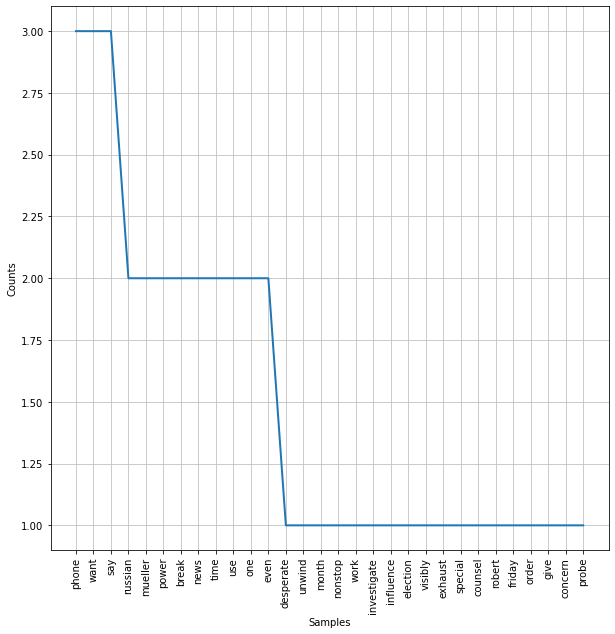

In [89]:
fdist = FreqDist(sample_doc_lemmed)
plt.figure(figsize=(10, 10))
fdist.plot(30);

-----


# Preparing Text for Modeling

The machine learning algorithms we have encountered so far represent features as the variables that take on different value for each observation. For example, we represent individuals with distinct education levels, incomes, and such. However, in NLP, features are represented in a very different way. In order to pass text data to machine learning algorithms and perform classification, we need to represent the features in a sensible way. One such method is called **Bag-of-words (BoW)**.

A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling. A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

- A vocabulary of known words.
- A measure of the presence of known words.

It is called a “bag” of words **because any information about the order or structure of words in the document is discarded**. The model is only concerned with whether known words occur in the document, not with **where** they may occur in the document. The intuition behind BoW is that a document is similar to another if they have similar contents. The Bag of Words method can be represented as a **Document Term Matrix**, in which each column is a unique vocabulary n-gram and each observation is a document. Consider, for example, the following **corpus** of documents:

- Document 1: "I love dogs."
- Document 2: "I love cats."
- Document 3: "I love all animals."
- Document 4: "I hate dogs."

This corpus can be represented as:

$\downarrow$Doc\|Word$\rightarrow$|I|love|dogs|cats|all|animals|hate
-|-|-|-|-|-|-|-
Document_1|1|1|1|0|0|0|0
Document_2|1|1|0|1|0|0|0
Document_3|1|1|0|0|1|1|0
Document_4|1|0|1|0|0|0|1

## Vectorization

In order to get these tokens from our documents, we're going to use tools called "vectorizers".

Documentation! https://scikit-learn.org/stable/modules/feature_extraction.html

### `CountVectorizer`

The most straightforward vectorizer in `sklearn.feature_extraction.text` is the `CountVectorizer`, which will simply count the number of each word type in each document.

In [ ]:
# Convert a collection of text documents to a matrix of token counts

# Note that our Vectorizer wants our text BEFORE tokenizing
# So we need to use .join to un-tokenize
X = [" ".join(sample_doc_lemmed)]

# Instantiate a CountVectorizer with just default arguments
vec = None
X_vec = None # Then fit_transform on X

df = pd.DataFrame(X_vec.toarray(), columns=vec.get_feature_names())
df.head()

That is not very exciting for one document. The idea is to make a document term matrix for all of the words in our corpus.

In [ ]:
# Revisit our corpus
corpus.head()

In [ ]:
# Note that our vectorizer can use that same regex pattern to tokenize 
# while removing punctuation, AND it'll remove stopwords!
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", 
                      stop_words=sw)
# Just exploring for the first 20 documents
X_vec = vec.fit_transform(corpus.body[:20])

df_tokens = pd.DataFrame(X_vec.toarray(), columns=vec.get_feature_names())
df_tokens.head()

In [ ]:
# We can expand the number of ngrams! AKA not single word tokens
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", 
                      stop_words=sw,
                      ngram_range=[1, 2])
# Just exploring for the first 20 documents
X_vec = vec.fit_transform(corpus.body[:20])

df_bigrams = pd.DataFrame(X_vec.toarray(), columns=vec.get_feature_names())
df_bigrams.head()

Our document term matrix gets bigger and bigger, with more and more zeros, becoming sparser and sparser.

In [ ]:
# One more time...
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", 
                      stop_words=sw,
                      ngram_range=[1, 2])
# But now fit to the entire corpus
X_vec = vec.fit_transform(corpus.body)

df = pd.DataFrame(X_vec.toarray(), columns=vec.get_feature_names())
df.head()

Luckily, we can set upper and lower limits to the word frequency:

In [ ]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
                      stop_words=sw, 
                      ngram_range=[1, 2],
                      min_df=2,  # Min # of times a word has to appear
                      max_df=100) # Max # of times a word has to appear
X_vec = vec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X_vec.toarray(), columns=vec.get_feature_names())
df_cv.head()

### `TfidfVectorizer`

There are many schemas for determining the values of each entry in a document term matrix, and one of the most common uses the TF-IDF algorithm -- "Term Frequency-Inverse Document Frequency". Essentially, tf-idf *normalizes* the raw count of the document term matrix. And it represents how important a word is in the given document. 

> The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

**TF (Term Frequency)**: Term frequency is the frequency of the word in the document divided by the total words in the document.

**IDF (inverse document frequency)**: Inverse document frequency is a measure of how much information the word provides, i.e., if it's common or rare across all documents. It is generally calculated as the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient):

$$\text{idf}(w) = log (\frac{\text{number of documents}}{\text{num of documents containing} w})$$

tf-idf is the product of term frequency and inverse document frequency, or tf * idf. 

In [ ]:
tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X_vec = tf_vec.fit_transform(corpus.body)

df = pd.DataFrame(X_vec.toarray(), columns=tf_vec.get_feature_names())
df.head()

In [ ]:
corpus.iloc[313].body

In [ ]:
df.iloc[313].sort_values(ascending=False)[:10]

Let's compare the tfidf to the count vectorizer output for one document.

In [ ]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X_vec = vec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X_vec.toarray(), columns=vec.get_feature_names())

In [ ]:
df_cv.iloc[313].sort_values(ascending=False)[:10]

The tfidf lessoned the importance of some of the more common words, including a word, "also", which might have made it into the stopword list.

It also assigns "nerds" more weight than power.  

In [ ]:
print(f'"Nerds" only shows up in document 313: {len(df_cv[df.nerds!=0])} document.')
print(f'"Power" shows up in {len(df_cv[df.power!=0])} documents!')

All the words are stored in a `.vocabulary_` attribute:

In [ ]:
tf_vec.vocabulary_

### `HashingVectorizer`

There is also a hashing vectorizer, which will encrypt all the words of the corpus.

In [ ]:
hvec = HashingVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
                         stop_words=sw)
X_vec = hvec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X_vec.toarray())
df_cv.head()

### Vectorizer Summary:

Some rules of thumb about these vectorizers:

**Tf-Idf**: Probably the most commonly used. Useful when the goal is to distinguish the **content** of documents from others in the corpus.

**Count**: Useful when the words themselves matter. If the goal is instead about identifying authors by their words, then the fact that some word appears in many documents of the corpus may be important.

**Hashing**: The advantage here is speed and low memory usage. The disadvantage is that you lose the identities of the words being tokenized. Useful for very large datasets where the ultimate model may be a bit of a black box.

## Exercise

For a final exercise, work through the following:

Create a document term matrix of the full 1000-document corpus. 

The vocabulary should have no stopwords, numbers, or punctuation, and it should be lemmatized. 

Use a `TfidfVectorizer`

In [ ]:
# Your code here!